# Data Dictionary

# [Link to dataset](https://www.kaggle.com/datasets/ang3loliveira/malware-analysis-datasets-api-call-sequences)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-za14{border-color:inherit;text-align:left;vertical-align:bottom}
.tg .tg-7zrl{text-align:left;vertical-align:bottom}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-za14">Column Name</th>
    <th class="tg-7zrl">Description</th>
    <th class="tg-7zrl">Data Type</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-7zrl">hash</td>
    <td class="tg-7zrl">Unique identifier for each record</td>
    <td class="tg-7zrl">Alphanumeric</td>
  </tr>
  <tr>
    <td class="tg-7zrl">t_0 - t_99</td>
    <td class="tg-7zrl">Time series measurement at index 0-99</td>
    <td class="tg-7zrl">Numerical (Float)</td>
  </tr>
  <tr>
    <td class="tg-7zrl">malware</td>
    <td class="tg-7zrl">Goodware (0) and Malware (1)</td>
    <td class="tg-7zrl">Categorical (Class)</td>
  </tr>
</tbody>
</table>

# Import necessary libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malware-analysis-datasets-api-call-sequences/dynamic_api_call_sequence_per_malware_100_0_306.csv


In [2]:
!pip install imblearn
!pip install imbalanced-learn==0.10.1
!pip install --upgrade imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl # Often used with matplotlib, so kept
import seaborn as sns
import os
import warnings

from sklearn.utils import shuffle
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    train_test_split
)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn import datasets # For loading toy datasets if used

from imblearn.over_sampling import SMOTE # From imbalanced-learn

import optuna

%matplotlib inline

print(f"Optuna Version: {optuna.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 11.3 MB/s eta 0:00:00
  Attempt

# Load Dataset

In [3]:
# reading data
df = pd.read_csv('/kaggle/input/malware-analysis-datasets-api-call-sequences/dynamic_api_call_sequence_per_malware_100_0_306.csv')
df.head()

hash  t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  \
0  071e8c3f8922e186e57548cd4c703a5d  112  274  158  215  274  158  215  298   
1  33f8e6d08a6aae939f25a8e0d63dd523   82  208  187  208  172  117  172  117   
2  b68abd064e975e1c6d5f25e748663076   16  110  240  117  240  117  240  117   
3  72049be7bd30ea61297ea624ae198067   82  208  187  208  172  117  172  117   
4  c9b3700a77facf29172f32df6bc77f48   82  240  117  240  117  240  117  240   

   t_8  ...  t_91  t_92  t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
0   76  ...    71   297   135   171   215    35   208    56    71        1  
1  172  ...    81   240   117    71   297   135   171   215    35        1  
2  240  ...    65   112   123    65   112   123    65   113   112        1  
3  172  ...   208   302   208   302   187   208   302   228   302        1  
4  117  ...   209   260    40   209   260   141   260   141   260        1  

[5 rows x 102 columns]

In [4]:
df = df.drop(columns=['hash'],axis=1)
df = df.dropna(how='any')
df

t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  t_9  ...  t_91  t_92  \
0      112  274  158  215  274  158  215  298   76  208  ...    71   297   
1       82  208  187  208  172  117  172  117  172  117  ...    81   240   
2       16  110  240  117  240  117  240  117  240  117  ...    65   112   
3       82  208  187  208  172  117  172  117  172  117  ...   208   302   
4       82  240  117  240  117  240  117  240  117  172  ...   209   260   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
43871   82  240  117  240  117  240  117  240  117  172  ...   141   260   
43872   82  240  117  240  117  240  117  240  117  172  ...   159   224   
43873   82  240  117  240  117  240  117  240  117  172  ...   260   141   
43874   82  240  117  240  117  240  117  240  117  172  ...   141   260   
43875  112  274  158  215  274  158  215  298   76  208  ...    71   297   

       t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
0       135   171   215    35   208    56    71        1  
1       117    71   297   135   171   215    35        1  
2       123    65   112   123    65   113   112        1  
3       208   302   187   208   302   228   302        1  
4        40   209   260   141   260   141   260        1  
...     ...   ...   ...   ...   ...   ...   ...      ...  
43871   141   260   141   260   141   260   141        1  
43872    82   159   224    82   159   224    82        1  
43873   260   141   260   141   260   141   260        1  
43874   141   260   141   260   141   260   141        1  
43875   135   171   215    35   208    56    71        1  

[43876 rows x 101 columns]

# Split Dataset

In [5]:
# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42) 

# Print the shapes of the resulting sets
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (35100, 101)
test shape: (8776, 101)


# Data Visualization

In [6]:
train.head()

t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  t_8  t_9  ...  t_91  t_92  \
35602  112  274  158  215  274  158  215  298   76  208  ...    71   297   
13858  112  274  158  215  274  158  215  298   76  208  ...   172   117   
39770  112  274  158  215  274  158  215  298   76  208  ...    71   297   
1024   208  286   76  110  240  117  208  187  208  198  ...   286   240   
31154   82  208  187  208  172  117  172  208   16  208  ...   117   172   

       t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
35602   135   171   215    35   208    56    71        1  
13858   172   117   172   117   172   117   172        1  
39770   135   171   215    35   208    56    71        1  
1024    286   117   208   286   240   286   117        1  
31154   117   208   172   117   100   215    35        1  

[5 rows x 101 columns]

In [7]:
train.describe()

t_0           t_1           t_2           t_3           t_4  \
count  35100.000000  35100.000000  35100.000000  35100.000000  35100.000000   
mean     142.787123    211.254872    148.203333    188.834245    187.417949   
std       75.600839     60.294950     47.698712     68.358486     71.255625   
min        2.000000      2.000000      2.000000      2.000000      0.000000   
25%       82.000000    172.000000    117.000000    117.000000    117.000000   
50%       82.000000    240.000000    158.000000    215.000000    172.000000   
75%      215.000000    240.000000    172.000000    240.000000    274.000000   
max      306.000000    306.000000    306.000000    306.000000    306.000000   

                t_5           t_6           t_7           t_8           t_9  \
count  35100.000000  35100.000000  35100.000000  35100.000000  35100.000000   
mean     174.108063    170.378148    199.045271    142.807322    167.325413   
std       65.739453     55.525942     65.516243     66.800136     53.441632   
min        0.000000      0.000000      2.000000      0.000000      2.000000   
25%      117.000000    117.000000    159.000000    117.000000    117.000000   
50%      158.000000    172.000000    215.000000    117.000000    172.000000   
75%      240.000000    215.000000    240.000000    208.000000    208.000000   
max      306.000000    306.000000    306.000000    306.000000    306.000000   

       ...          t_91          t_92          t_93          t_94  \
count  ...  35100.000000  35100.000000  35100.000000  35100.000000   
mean   ...    154.204786    173.156809    159.560484    164.906980   
std    ...     78.291792     82.742852     74.071577     70.322547   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...     81.000000    117.000000    114.000000    117.000000   
50%    ...    141.000000    172.000000    141.000000    171.000000   
75%    ...    240.000000    260.000000    240.000000    215.000000   
max    ...    306.000000    306.000000    306.000000    306.000000   

               t_95          t_96          t_97          t_98          t_99  \
count  35100.000000  35100.000000  35100.000000  35100.000000  35100.000000   
mean     173.463419    152.373533    158.394758    160.395926    155.748262   
std       70.531624     79.906061     78.029384     75.022546     78.949398   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      117.000000     89.000000    100.000000    108.000000     73.000000   
50%      172.000000    141.000000    171.000000    156.000000    141.000000   
75%      240.000000    215.000000    224.000000    225.000000    225.000000   
max      306.000000    306.000000    306.000000    306.000000    306.000000   

            malware  
count  35100.000000  
mean       0.975698  
std        0.153987  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  

[8 rows x 101 columns]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35100 entries, 35602 to 15795
Columns: 101 entries, t_0 to malware
dtypes: int64(101)
memory usage: 27.3 MB


In [9]:
train.isnull().sum()

t_0        0
t_1        0
t_2        0
t_3        0
t_4        0
          ..
t_96       0
t_97       0
t_98       0
t_99       0
malware    0
Length: 101, dtype: int64

In [10]:
test.isnull().sum()

t_0        0
t_1        0
t_2        0
t_3        0
t_4        0
          ..
t_96       0
t_97       0
t_98       0
t_99       0
malware    0
Length: 101, dtype: int64

In [11]:
train['malware'].value_counts(normalize=True)*100

malware
1    97.569801
0     2.430199
Name: proportion, dtype: float64

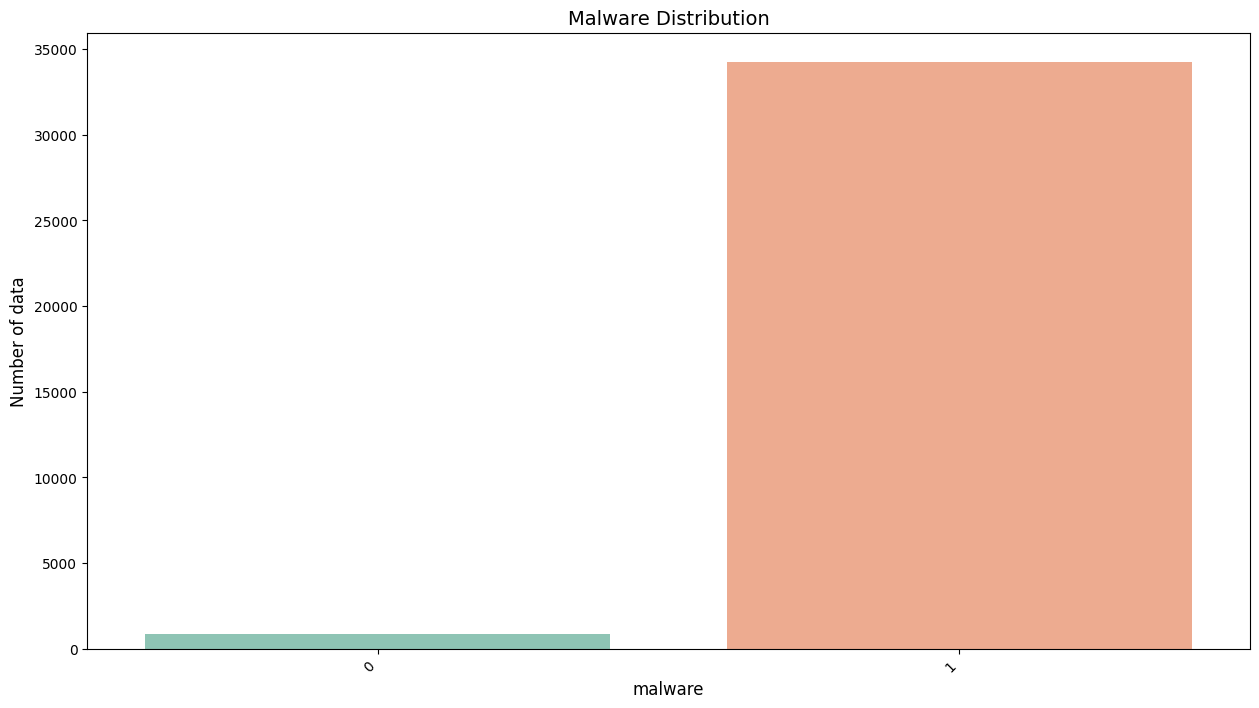

In [12]:
cnt_pro = train['malware'].value_counts()

plt.figure(figsize=(15,8))
# Assign the barplot to an axes object 'ax'
ax = sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8, palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.ylabel('Number of data', fontsize=12)
plt.xlabel('malware', fontsize=12)
# Remove the duplicate plt.xticks(rotation=90) as ax.set_xticklabels handles rotation
# plt.xticks(rotation=90)
plt.title('Malware Distribution', fontsize=14)
plt.show()

# Feature Engineer

## Split into x and y

In [13]:
x_train = train.drop('malware', axis=1) 
y_train = train['malware'] 
x_test = test.drop('malware', axis=1) 
y_test = test['malware'] 

# Print the shapes of the resulting sets
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35100, 100)
y_train shape: (35100,)
X_test shape: (8776, 100)
y_test shape: (8776,)


## Data Normalization

In [14]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
x_train_std = scaler.fit_transform(x_train)
# Transform the test data using the fitted scaler
x_test_std = scaler.transform(x_test)

In [15]:
# Convert the scaled data back to DataFrames
x_train_std = pd.DataFrame(x_train_std, columns=x_train.columns)
x_test_std = pd.DataFrame(x_test_std, columns=x_test.columns)
x_train_std.describe()

t_0           t_1           t_2           t_3           t_4  \
count  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04   
mean  -1.530400e-16 -1.220676e-16 -2.702492e-16 -1.805710e-16 -1.781418e-17   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -1.862269e+00 -3.470570e+00 -3.065186e+00 -2.733193e+00 -2.630257e+00   
25%   -8.040650e-01 -6.510567e-01 -6.541849e-01 -1.050861e+00 -9.882581e-01   
50%   -8.040650e-01  4.767487e-01  2.053893e-01  3.827780e-01 -2.163783e-01   
75%    9.551998e-01  4.767487e-01  4.989025e-01  7.485023e-01  1.215108e+00   
max    2.158907e+00  1.571383e+00  3.308243e+00  1.714014e+00  1.664202e+00   

                t_5           t_6           t_7           t_8           t_9  \
count  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04   
mean  -6.498126e-17  7.530538e-17  8.502221e-18 -1.064802e-16  2.206529e-17   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -2.648494e+00 -3.068486e+00 -3.007622e+00 -2.137860e+00 -3.093614e+00   
25%   -8.687154e-01 -9.613328e-01 -6.112353e-01 -3.863419e-01 -9.417027e-01   
50%   -2.450323e-01  2.920932e-02  2.435267e-01 -3.863419e-01  8.747213e-02   
75%    1.002334e+00  8.036331e-01  6.251169e-01  9.759502e-01  7.611139e-01   
max    2.006311e+00  2.442530e+00  1.632515e+00  2.443034e+00  2.594916e+00   

       ...          t_90          t_91          t_92          t_93  \
count  ...  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04   
mean   ...  3.623566e-17  1.651860e-16  2.753100e-17 -1.615422e-16   
std    ...  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min    ... -1.988217e+00 -1.969644e+00 -2.092740e+00 -2.154170e+00   
25%    ... -5.210352e-01 -9.350384e-01 -6.787004e-01 -6.150960e-01   
50%    ... -6.894509e-03 -1.686636e-01 -1.398097e-02 -2.505786e-01   
75%    ...  1.021387e+00  1.095855e+00  1.049570e+00  1.085986e+00   
max    ...  1.849028e+00  1.938867e+00  1.605517e+00  1.977028e+00   

               t_94          t_95          t_96          t_97          t_98  \
count  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04  3.510000e+04   
mean   1.595179e-16  2.200456e-16  1.388696e-16  1.046583e-16  2.672127e-17   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -2.345042e+00 -2.459406e+00 -1.906935e+00 -2.029966e+00 -2.138000e+00   
25%   -6.812561e-01 -8.005519e-01 -7.931117e-01 -7.483795e-01 -6.984123e-01   
50%    8.664514e-02 -2.074870e-02 -1.423383e-01  1.615471e-01 -5.859557e-02   
75%    7.123424e-01  9.433716e-01  7.837623e-01  8.407881e-01  8.611411e-01   
max    2.006398e+00  1.879135e+00  1.922616e+00  1.891689e+00  1.940832e+00   

               t_99  
count  3.510000e+04  
mean  -2.186285e-17  
std    1.000014e+00  
min   -1.972789e+00  
25%   -1.048133e+00  
50%   -1.868092e-01  
75%    8.771786e-01  
max    1.903167e+00  

[8 rows x 100 columns]

## Dimensionality reduction

In [16]:
# --- Apply PCA for dimensionality reduction ---
# Initialize PCA with the desired number of components.  For example, to reduce to 2 dimensions
pca = PCA(n_components=2) # You can change n_components as needed
# Fit PCA on the scaled training data and transform it.
x_train = pca.fit_transform(x_train_std)
# Transform the scaled test data using the fitted PCA.
x_test = pca.transform(x_test_std)

## Visualiza data after dimensionality reduction (before oversampling)

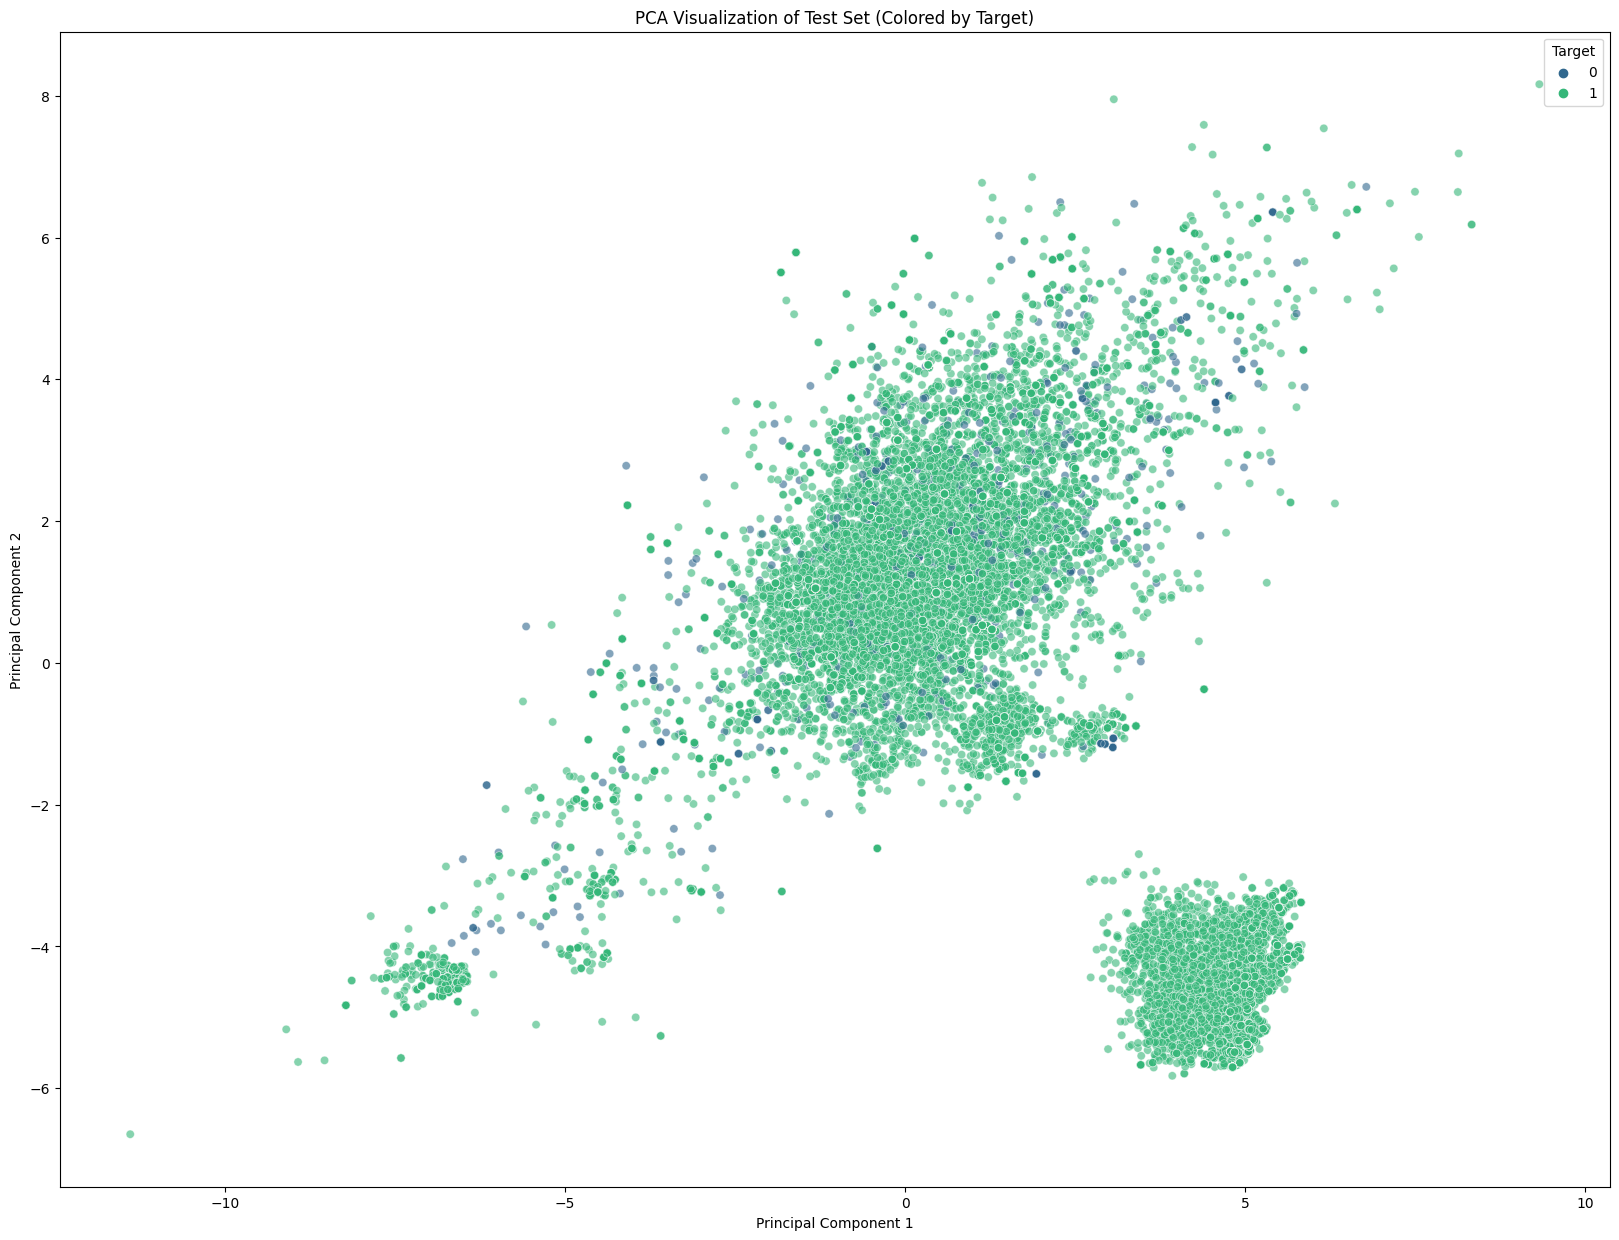

In [17]:
# --- Visualize the PCA-transformed data ---

# Create a DataFrame for the test set PCA components
plot_data = pd.DataFrame({
    'PC1': x_train[:, 0],  # First principal component
    'PC2': x_train[:, 1],  # Second principal component
    'Target': y_train         # Target variable for coloring
})

# Create the scatter plot
plt.figure(figsize=(20, 15))
sns.scatterplot(
    data=plot_data,
    x="PC1",
    y="PC2",
    hue="Target",  # Color by target variable (e.g., charges)
    palette="viridis",  # Continuous palette for charges
    alpha=0.6  # Slight transparency for overlapping points
)

# Set labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Test Set (Colored by Target)")

# Optionally add a regression line (if desired)
# sns.regplot(data=plot_data, x="PC1", y="PC2", scatter=False, color="blue")

# Show the plot
plt.show()

## Oversampling

In [18]:
smote = SMOTE(random_state=42)
print("Shape of original x_train:", x_train.shape)
print("Shape of original y_train:", y_train.shape)
x_train, y_train = smote.fit_resample(x_train, y_train)
# Print the shapes of the original and resampled data to see the effect
print("Shape of original x_train:", x_train.shape)
print("Shape of original y_train:", y_train.shape)
y_train.value_counts(normalize=True)*100

Shape of original x_train: (35100, 2)
Shape of original y_train: (35100,)
Shape of original x_train: (68494, 2)
Shape of original y_train: (68494,)


malware
1    50.0
0    50.0
Name: proportion, dtype: float64

## Visualize data after oversampling

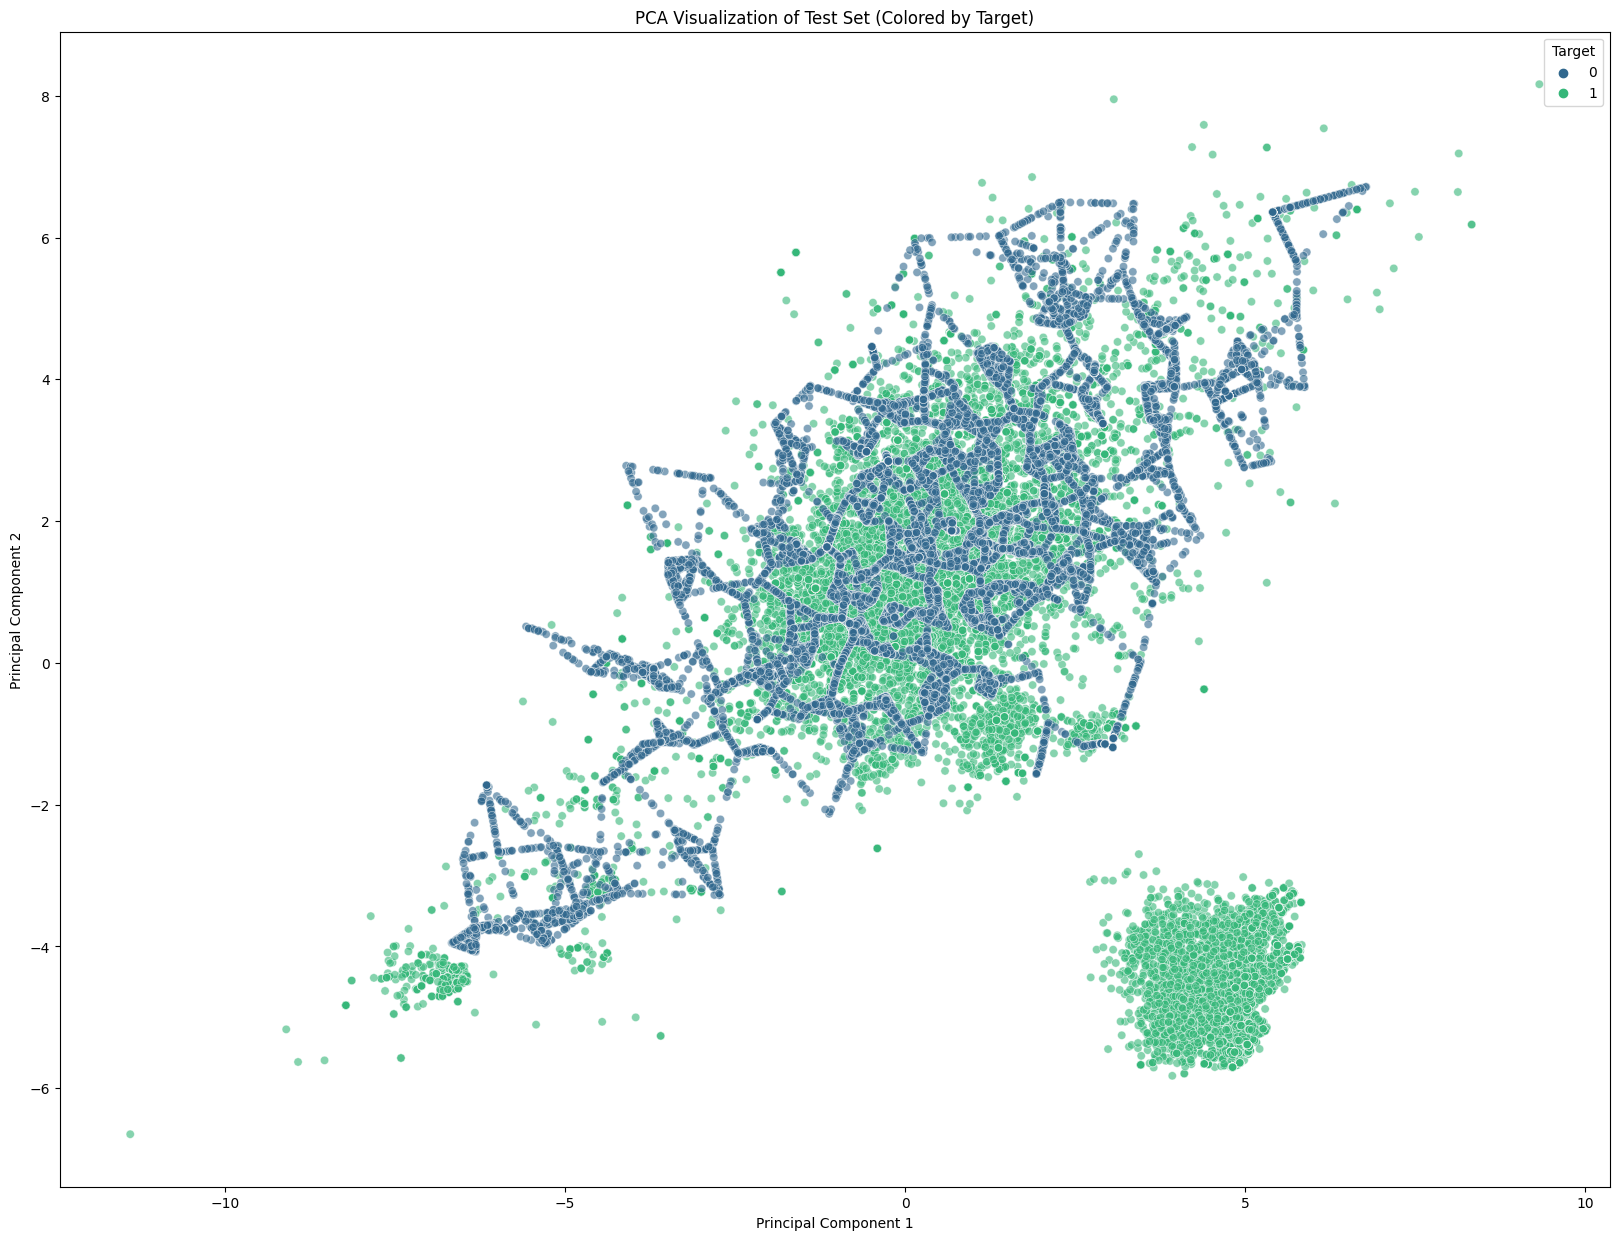

In [19]:
# --- Visualize the PCA-transformed data ---

# Create a DataFrame for the test set PCA components
plot_data = pd.DataFrame({
    'PC1': x_train[:, 0],  # First principal component
    'PC2': x_train[:, 1],  # Second principal component
    'Target': y_train         # Target variable for coloring
})

# Create the scatter plot
plt.figure(figsize=(20, 15))
sns.scatterplot(
    data=plot_data,
    x="PC1",
    y="PC2",
    hue="Target",  # Color by target variable (e.g., charges)
    palette="viridis",  # Continuous palette for charges
    alpha=0.6  # Slight transparency for overlapping points
)

# Set labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Test Set (Colored by Target)")

# Optionally add a regression line (if desired)
# sns.regplot(data=plot_data, x="PC1", y="PC2", scatter=False, color="blue")

# Show the plot
plt.show()

# Modeling and Experiments

## Training model

In [20]:
# Define the list of models for multi-class classification
# Changed to use only Perceptron
ml_models = [
    ("MLPClassifier", MLPClassifier(random_state=42)) # Added tol and eta0 for convergence
]

# Perform cross-validation for each model
for model_name, model in ml_models:
    print(f"{model_name}: ")
    model.fit(x_train, y_train)  # Fit on training data
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')  # Cross-validation
    print("\tStratified K-Fold Cross-Validation Scores:", cv_scores)
    print('-' * 100)
    print(f'\tAverage Stratified K-Fold Cross-Validation Score: {cv_scores.mean():.4f}')
    print('-' * 100)

MLPClassifier: 


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

	Stratified K-Fold Cross-Validation Scores: [0.78494781 0.77881597 0.79312359 0.79151763 0.78639217]
----------------------------------------------------------------------------------------------------
	Average Stratified K-Fold Cross-Validation Score: 0.7870
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Training performance of a Multi-layer Perceptron (MLP) Classifier using different optimization algorithms and learning rate schedules.


learning on dataset iris
training: constant learning-rate
Training set score: 0.980000
Training set loss: 0.096950
training: constant with momentum
Training set score: 0.980000
Training set loss: 0.049530
training: constant with Nesterov's momentum
Training set score: 0.980000
Training set loss: 0.049540
training: inv-scaling learning-rate
Training set score: 0.360000
Training set loss: 0.978444
training: inv-scaling with momentum
Training set score: 0.860000
Training set loss: 0.504185
training: inv-scaling with Nesterov's momentum
Training set score: 0.860000
Training set loss: 0.503452
training: adam
Training set score: 0.980000
Training set loss: 0.045311

learning on dataset digits
training: constant learning-rate
Training set score: 0.956038
Training set loss: 0.243802
training: constant with momentum
Training set score: 0.992766
Training set loss: 0.041297
training: constant with Nesterov's momentum
Training set score: 0.993879
Training set loss: 0.042898
training: inv-scaling 

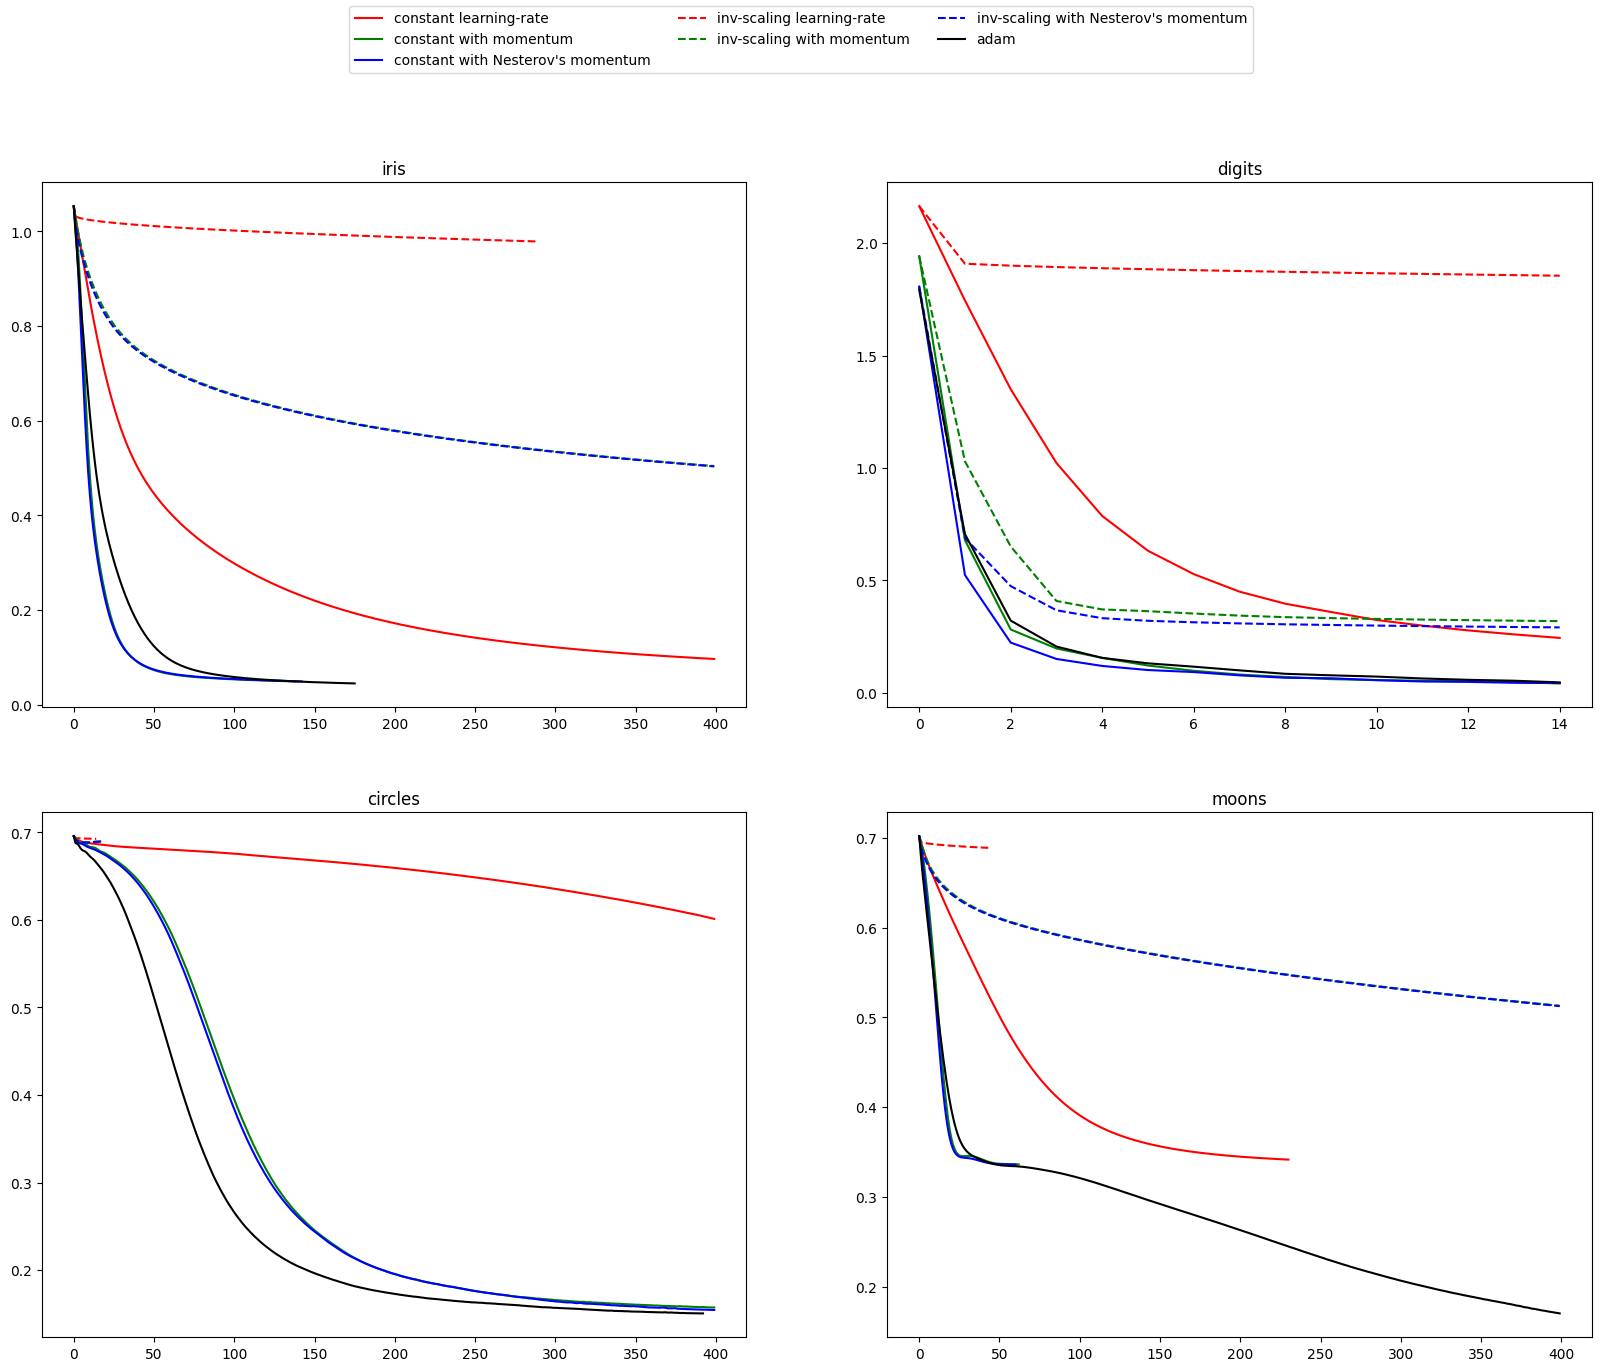

In [21]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

# different learning rate schedules and momentum parameters
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {"solver": "adam", "learning_rate_init": 0.01},
]

labels = [
    "constant learning-rate",
    "constant with momentum",
    "constant with Nesterov's momentum",
    "inv-scaling learning-rate",
    "inv-scaling with momentum",
    "inv-scaling with Nesterov's momentum",
    "adam",
]

plot_args = [
    {"c": "red", "linestyle": "-"},
    {"c": "green", "linestyle": "-"},
    {"c": "blue", "linestyle": "-"},
    {"c": "red", "linestyle": "--"},
    {"c": "green", "linestyle": "--"},
    {"c": "blue", "linestyle": "--"},
    {"c": "black", "linestyle": "-"},
]

def plot_on_dataset(x_train, y_train, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)

    x_train = MinMaxScaler().fit_transform(x_train)
    mlps = []
    if name == "digits":
        # digits is larger but converges fairly quickly
        max_iter = 15
    else:
        max_iter = 400

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(random_state=0, max_iter=max_iter, **param)

        # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore", category=ConvergenceWarning, module="sklearn"
            )
            mlp.fit(x_train, y_train)

        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(x_train, y_train))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
# load / generate some toy datasets
iris = datasets.load_iris()
x_train_digits, y_train_digits = datasets.load_digits(return_X_y=True)
data_sets = [
    (iris.data, iris.target),
    (x_train_digits, y_train_digits),
    datasets.make_circles(noise=0.2, factor=0.5, random_state=1),
    datasets.make_moons(noise=0.3, random_state=0),
]

for ax, data, name in zip(
    axes.ravel(), data_sets, ["iris", "digits", "circles", "moons"]
):
    plot_on_dataset(*data, ax=ax, name=name)

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

## Hyperparameter tuning (Optuna)

In [22]:
# --- Define the Optuna Objective Function for MLPClassifier ---
def objective(trial):
    """
    Objective function for Optuna to optimize MLPClassifier hyperparameters.
    """
    # Define hyperparameters to tune
    # Convert tuples to strings for Optuna's categorical sampler to avoid UserWarning
    hidden_layer_sizes_str = trial.suggest_categorical(
        "hidden_layer_sizes", ["(50,)", "(100,)", "(50, 50)", "(100, 50)"]
    )
    # Convert the selected string back to a tuple
    # Using eval() is safe here because the input strings are controlled.
    hidden_layer_sizes = eval(hidden_layer_sizes_str)

    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True) # L2 penalty (regularization) parameter

    # Solver-specific parameters
    if solver == "sgd":
        learning_rate_init = trial.suggest_float("learning_rate_init", 1e-3, 1e-1, log=True)
        momentum = trial.suggest_float("momentum", 0.0, 0.9)
        nesterovs_momentum = trial.suggest_categorical("nesterovs_momentum", [True, False])
    else: # adam
        learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True)
        momentum = 0.0 # Not used by adam, set to default
        nesterovs_momentum = False # Not used by adam, set to default

    # Initialize MLPClassifier with suggested parameters
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes, # Use the converted tuple here
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        momentum=momentum,
        nesterovs_momentum=nesterovs_momentum,
        max_iter=500, # Fixed max_iter, can also be tuned
        random_state=42,
        early_stopping=True, # Enable early stopping for faster trials
        validation_fraction=0.1,
        n_iter_no_change=10, # Changed from 5 to 10 for more stability in tuning
        verbose=False # Keep verbose false during tuning
    )

    # Train the model on PCA-transformed training data
    mlp.fit(x_train, y_train) # Changed to x_train_pca as per previous context

    # Return the accuracy on the validation set (from early_stopping) or training accuracy
    # For Optuna, we typically want to maximize a validation metric.
    # MLPClassifier's early_stopping uses a validation set internally.
    # We can use the final training score as the objective for simplicity here,
    # or implement cross-validation within the objective for more robust tuning.
    # For now, let's use the accuracy on the training data after fitting.
    accuracy = mlp.score(x_train, y_train) # Changed to x_train_pca as per previous context
    return accuracy

# --- Perform Hyperparameter Tuning with Optuna ---
print("\nStarting Optuna hyperparameter tuning for MLPClassifier...")
study = optuna.create_study(direction="maximize") # We want to maximize accuracy
study.optimize(objective, n_trials=20) # Run 50 trials (can be increased)

print("\nOptuna tuning complete.")
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial: {study.best_trial.value:.4f} with parameters: {study.best_trial.params}")

# --- Train the final MLPClassifier with the best parameters ---
best_mlp_params = study.best_trial.params
# Convert hidden_layer_sizes string back to tuple for the final model
best_mlp_params['hidden_layer_sizes'] = eval(best_mlp_params['hidden_layer_sizes'])

final_mlp_model = MLPClassifier(
    **best_mlp_params,
    max_iter=1000, # Potentially increase max_iter for the final model
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10, # Consistent with objective function
    verbose=True # Set verbose to True for final training
)

print("\nTraining final MLPClassifier with best parameters...")
final_mlp_model.fit(x_train, y_train) # Changed to x_train_pca as per previous context
print("Final MLPClassifier training complete.")

[I 2025-07-22 16:38:36,615] A new study created in memory with name: no-name-846abd43-13c7-49a2-8cd1-c5321cc3295f



Starting Optuna hyperparameter tuning for MLPClassifier...


[I 2025-07-22 16:39:04,782] Trial 0 finished with value: 0.7797033316786872 and parameters: {'hidden_layer_sizes': '(50, 50)', 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0002778229953915241, 'learning_rate_init': 0.0018852855486312227}. Best is trial 0 with value: 0.7797033316786872.
[I 2025-07-22 16:39:16,645] Trial 1 finished with value: 0.7257862002511168 and parameters: {'hidden_layer_sizes': '(100, 50)', 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.00017388356172318715, 'learning_rate_init': 0.09981055303637827, 'momentum': 0.6128710924215401, 'nesterovs_momentum': False}. Best is trial 0 with value: 0.7797033316786872.
[I 2025-07-22 16:39:23,369] Trial 2 finished with value: 0.649414547259614 and parameters: {'hidden_layer_sizes': '(50,)', 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0009025042537616443, 'learning_rate_init': 0.007569946998923739, 'momentum': 0.12337512645800318, 'nesterovs_momentum': True}. Best is trial 0 with value: 0.779703331678


Optuna tuning complete.
Number of finished trials: 20
Best trial: 0.8546 with parameters: {'hidden_layer_sizes': '(100, 50)', 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00012026294637574818, 'learning_rate_init': 0.0006395682350792203}

Training final MLPClassifier with best parameters...
Iteration 1, loss = 0.59476620
Validation score: 0.678394
Iteration 2, loss = 0.54843489
Validation score: 0.700876
Iteration 3, loss = 0.52984677
Validation score: 0.698978
Iteration 4, loss = 0.51790562
Validation score: 0.711679
Iteration 5, loss = 0.50189545
Validation score: 0.715328
Iteration 6, loss = 0.48453503
Validation score: 0.732555
Iteration 7, loss = 0.47158495
Validation score: 0.732117
Iteration 8, loss = 0.46154955
Validation score: 0.746423
Iteration 9, loss = 0.45418483
Validation score: 0.751533
Iteration 10, loss = 0.44802829
Validation score: 0.757956
Iteration 11, loss = 0.44267604
Validation score: 0.763650
Iteration 12, loss = 0.43769662
Validation score: 0.762920
It

## Visualize the Decision Boundary

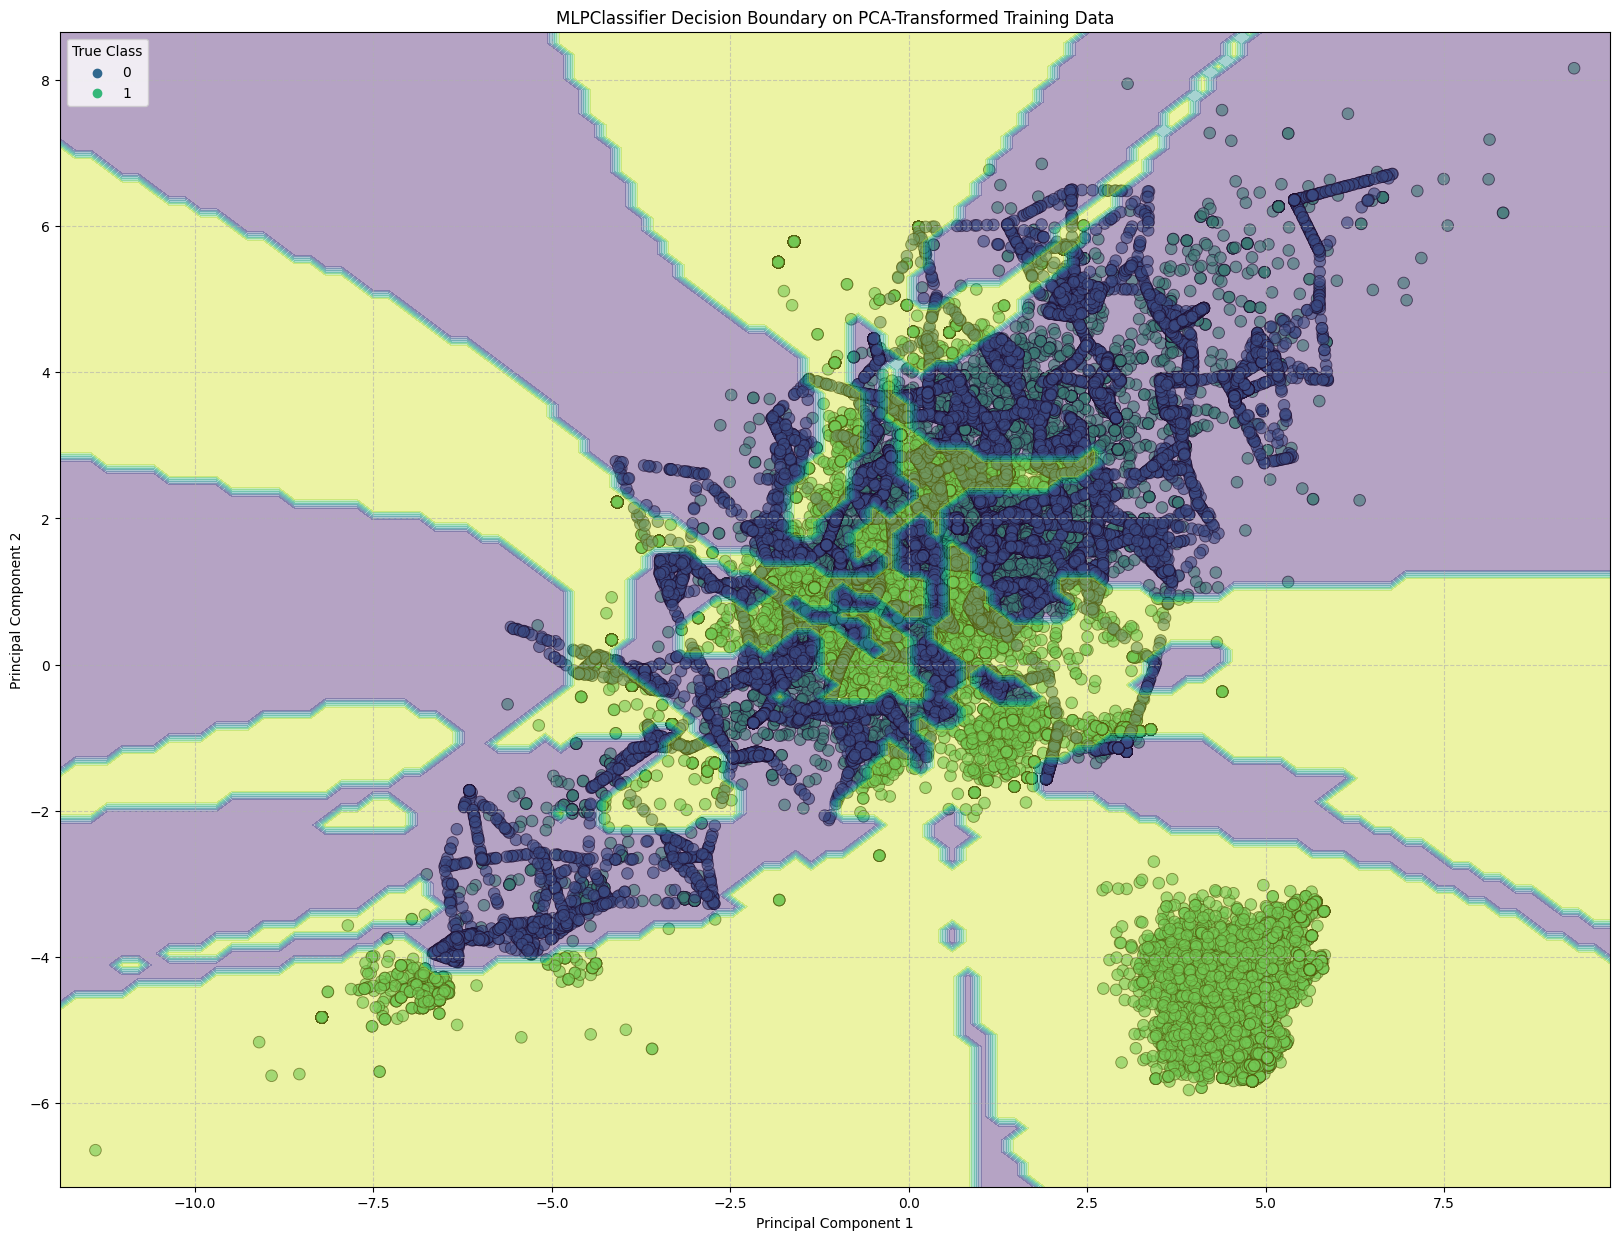

In [23]:
# --- Visualize the Decision Boundary of the MLP ---

# Create a DataFrame for the PCA-transformed training components for plotting
plot_data_train = pd.DataFrame({
    'PC1': x_train[:, 0],
    'PC2': x_train[:, 1],
    'Target': y_train
})

# Create the scatter plot with the specified figure size
plt.figure(figsize=(20, 15)) # Increased figure size as requested
sns.scatterplot(
    data=plot_data_train,
    x="PC1",
    y="PC2",
    hue="Target",
    palette="viridis",
    alpha=0.6, # Alpha as requested
    edgecolor='k', # Add black edges to points for better visibility
    s=70 # Size of the points
)

# Create a meshgrid to plot the decision boundary
x_min, x_max = x_train[:, 0].min() - 0.5, x_train[:, 0].max() + 0.5
y_min, y_max = x_train[:, 1].min() - 0.5, x_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict class for each point in the meshgrid
Z = final_mlp_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary as a filled contour
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis)


# Set labels and title
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("MLPClassifier Decision Boundary on PCA-Transformed Training Data")
plt.legend(title="True Class")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Model Evaluation

In [24]:
# Evaluate the MLP on the PCA-transformed test data
test_accuracy = final_mlp_model.score(x_test, y_test)
print(f"MLPClassifier Test Accuracy (on PCA data): {test_accuracy:.4f}")

MLPClassifier Test Accuracy (on PCA data): 0.8053


## Classification metrics and classification reports evaluation

In [25]:
# --- Performance Metrics on Test Data ---
print("\n--- Performance Metrics on Test Data (Optuna Tuned MLPClassifier) ---")

# Make predictions on the scaled test data
# IMPORTANT: use x_test_pca for predictions as the model was trained on PCA-transformed data
y_pred_proba_test = final_mlp_model.predict_proba(x_test)[:, 1] # Probabilities for positive class
y_pred_test = (y_pred_proba_test > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate metrics
cm = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro', zero_division=1)
recall = recall_score(y_test, y_pred_test, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=1)

# Calculate ROC-AUC for binary classification
roc_auc_val = roc_auc_score(y_test, y_pred_proba_test)

# Print the results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"AUC-ROC: {roc_auc_val:.3f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, zero_division=1))


--- Performance Metrics on Test Data (Optuna Tuned MLPClassifier) ---
Accuracy: 0.805
Precision: 0.545
Recall: 0.799
F1-score: 0.531
AUC-ROC: 0.895

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.79      0.17       226
           1       0.99      0.81      0.89      8550

    accuracy                           0.81      8776
   macro avg       0.55      0.80      0.53      8776
weighted avg       0.97      0.81      0.87      8776



## Confusion metrics

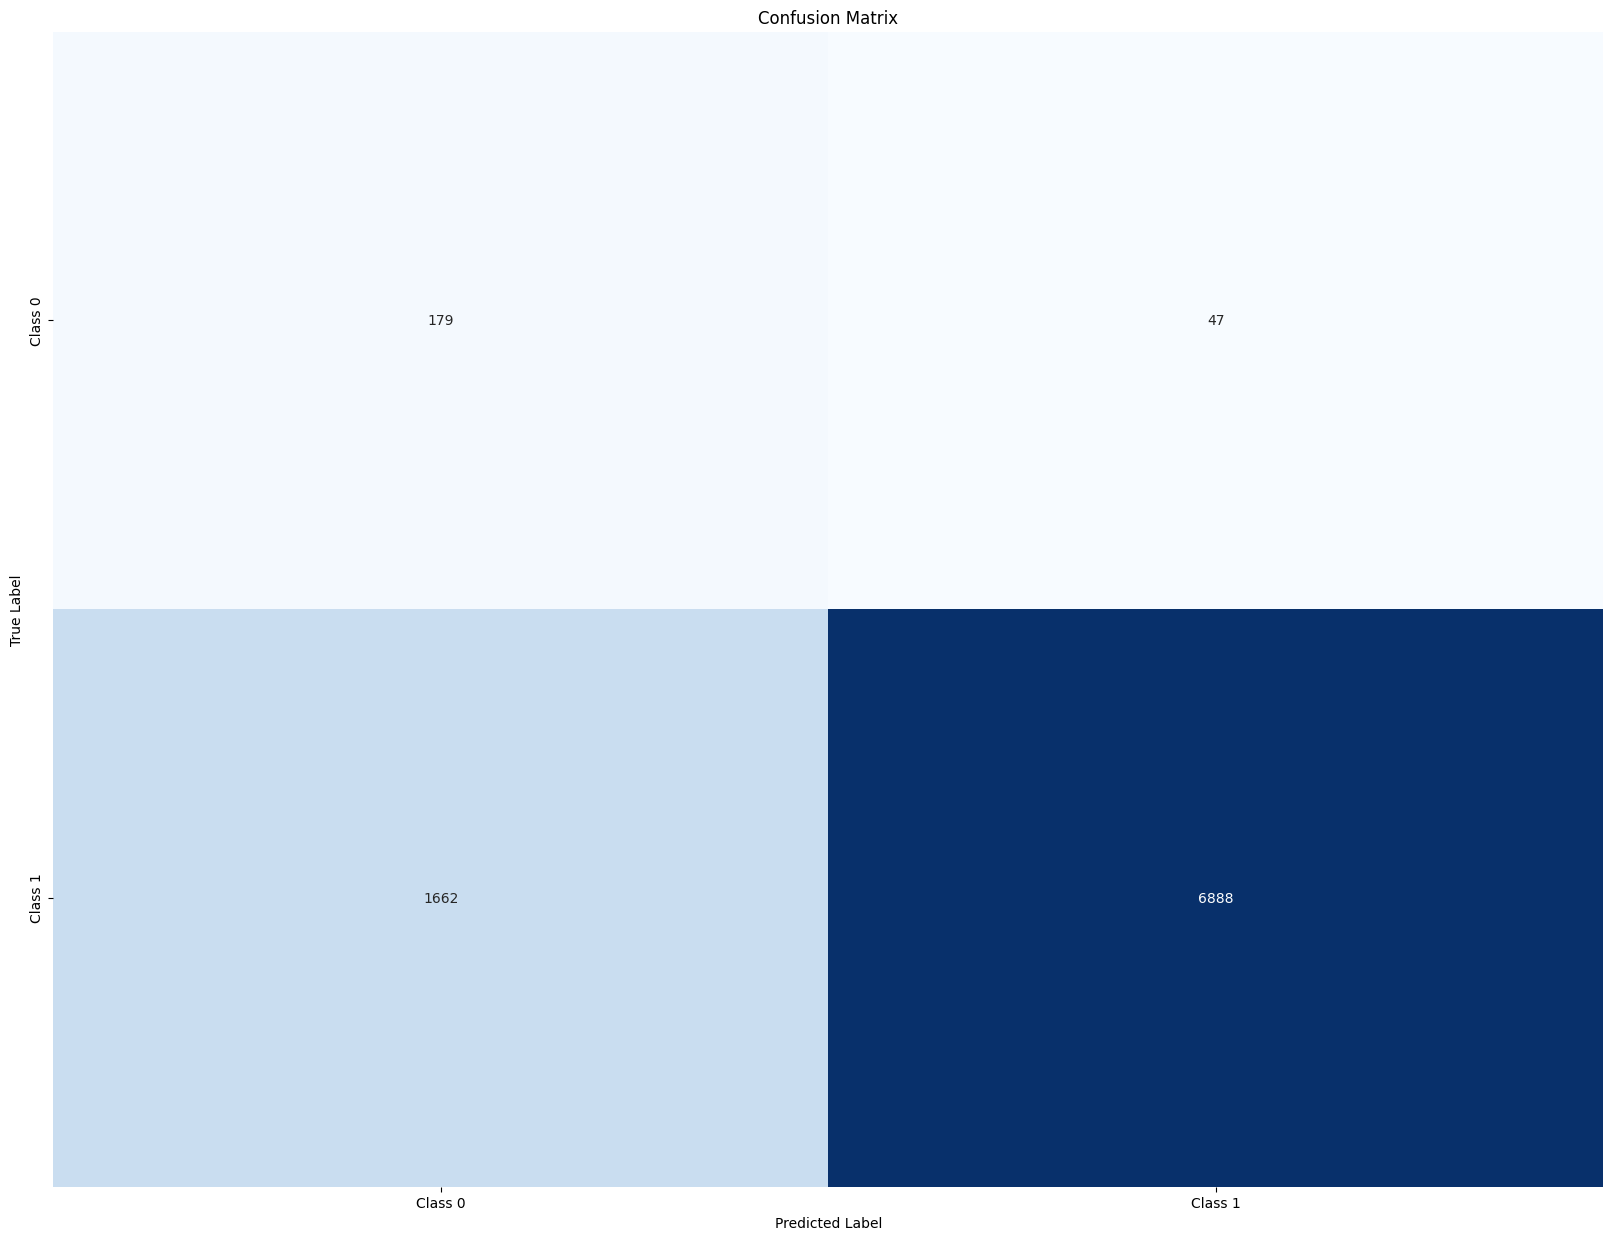

In [26]:
# --- Plotting Confusion Matrix ---
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Precision Recall Curve


--- Plotting Precision-Recall Curve (Optuna Tuned MLPClassifier) ---


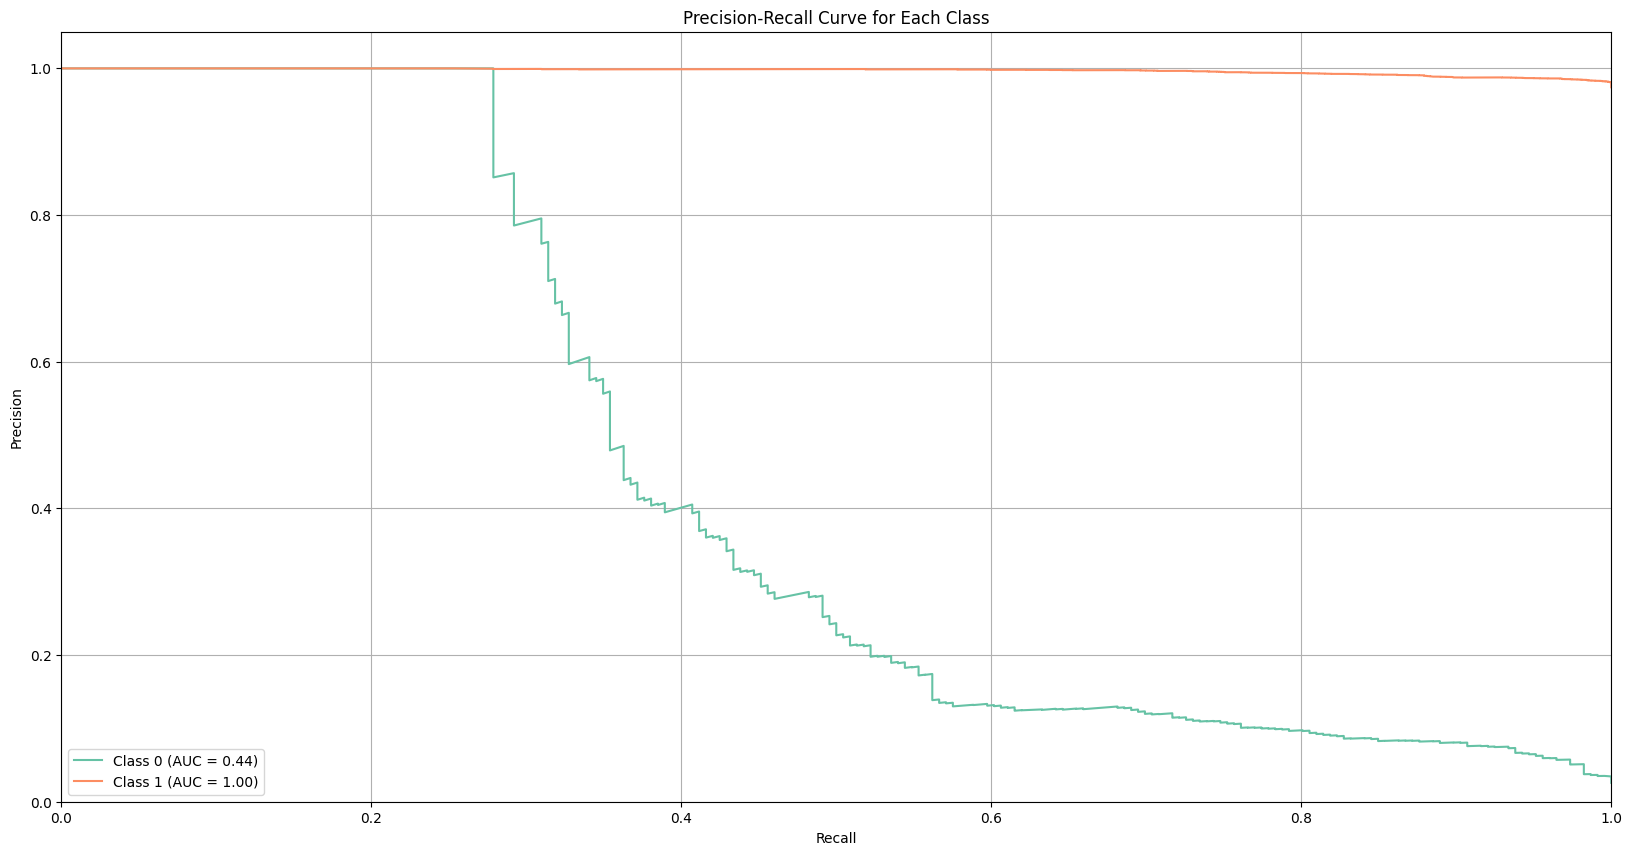

In [27]:
# --- Plotting Precision-Recall Curve ---
print("\n--- Plotting Precision-Recall Curve (Optuna Tuned MLPClassifier) ---")

# Define class labels (for binary classification, 0 and 1)
class_labels = ["0", "1"]

# Initialize a plot
plt.figure(figsize=(20, 10))

# Set Seaborn color palette
sns.set_palette("Set2")

# Get the prediction probabilities for the test set
y_pred_proba_test_pr = final_mlp_model.predict_proba(x_test)[:, 1]

# Generate Precision-Recall curve for each class
for i, label in enumerate(class_labels):
    y_test_bin = np.where(y_test == int(label), 1, 0)

    if int(label) == 1: # For positive class (1)
        y_pred_score = y_pred_proba_test_pr
    else: # For negative class (0), use 1 - probabilities
        y_pred_score = 1 - y_pred_proba_test_pr

    precision, recall, _ = precision_recall_curve(y_test_bin, y_pred_score)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f'Class {label} (AUC = {pr_auc:.2f})')

# Add plot details
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend(loc="lower left")
plt.ylim([0, 1.05])
plt.xlim([0, 1])
plt.grid(True)

plt.show()

## ROC AUC Curve


--- Plot ROC Curve for Label 0 and 1 (Optuna Tuned MLPClassifier) ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

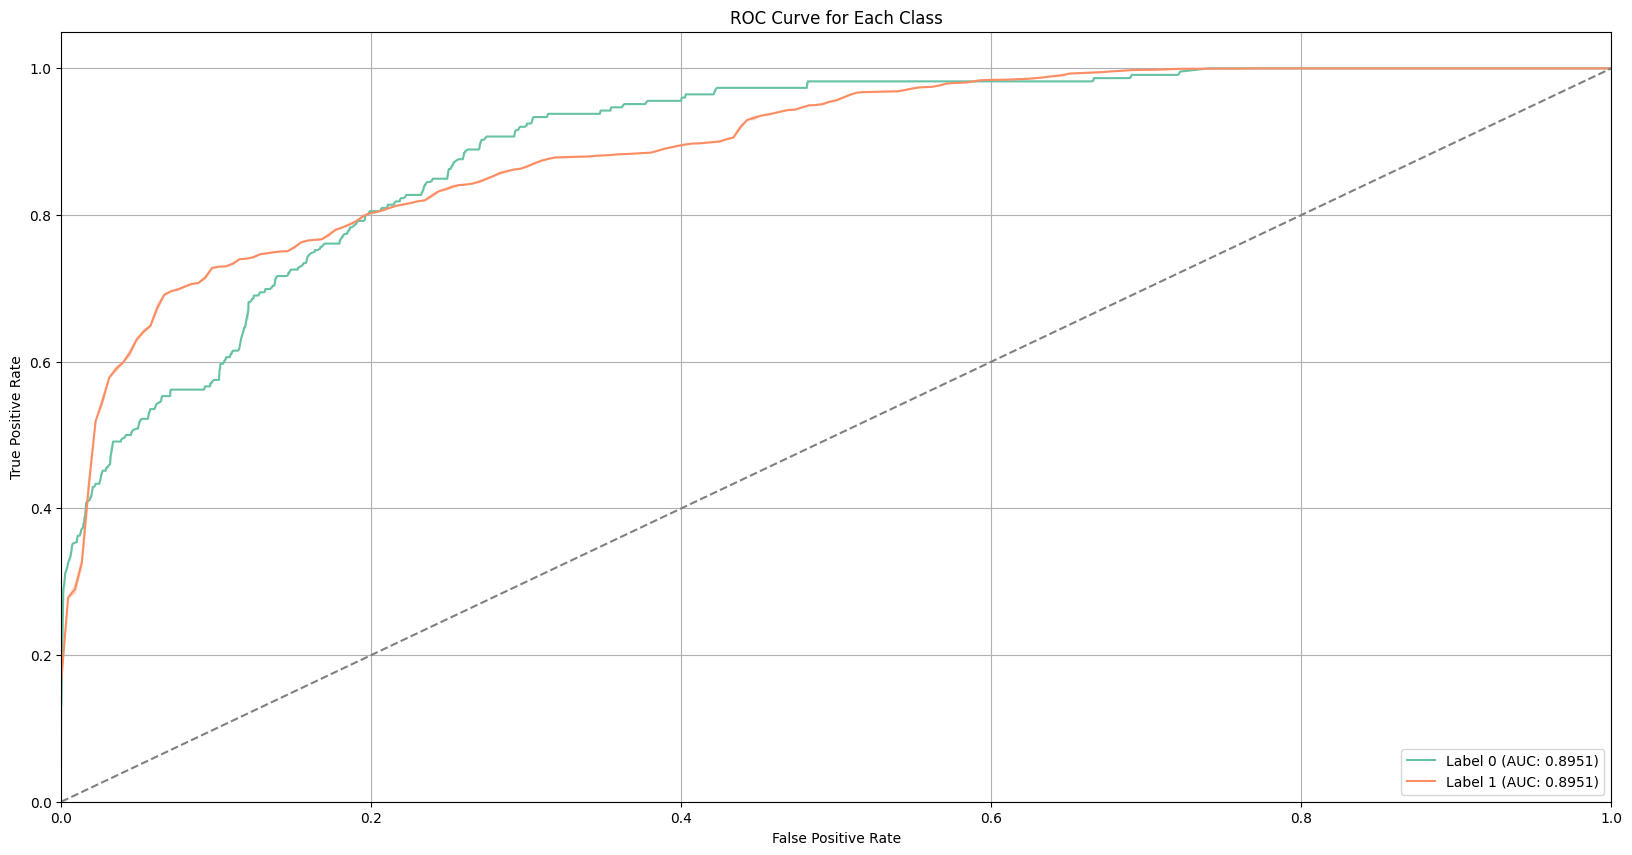


--- AUC ROC Values per Class ---
Label 0 AUC: 0.8951
Label 1 AUC: 0.8951
------------------------------


In [28]:
# --- Plot ROC Curve for Label 0 and 1 ---
print("\n--- Plot ROC Curve for Label 0 and 1 (Optuna Tuned MLPClassifier) ---")

# Get prediction probabilities for the test set
y_pred_proba_roc = final_mlp_model.predict_proba(x_test)[:, 1]

# Define class labels for plotting
class_labels_roc = ["Label 0", "Label 1"]
classes_roc = [0, 1]

# Initialize ROC curve and AUC dictionaries
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()

# Create a new figure using Seaborn
plt.figure(figsize=(20, 10))

# Set Seaborn color palette
sns.set_palette("Set2")

# Loop over each class and calculate the ROC curve and AUC score
for i, class_val in enumerate(classes_roc):
    if class_val == 1: # For Label 1 (positive class)
        fpr[class_val], tpr[class_val], _ = roc_curve(y_test, y_pred_proba_roc)
    else: # For Label 0 (negative class)
        fpr[class_val], tpr[class_val], _ = roc_curve(1 - y_test, 1 - y_pred_proba_roc)

    roc_auc_per_class[class_val] = auc(fpr[class_val], tpr[class_val])

    sns.lineplot(x=fpr[class_val], y=tpr[class_val], label=f'{class_labels_roc[i]} (AUC: {roc_auc_per_class[class_val]:.4f})')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

# Show AUC values for each class
print("\n--- AUC ROC Values per Class ---")
for class_val in classes_roc:
    print(f"{class_labels_roc[class_val]} AUC: {roc_auc_per_class[class_val]:.4f}")
print("-" * 30)

## Decision Boundary (Test Dataset)

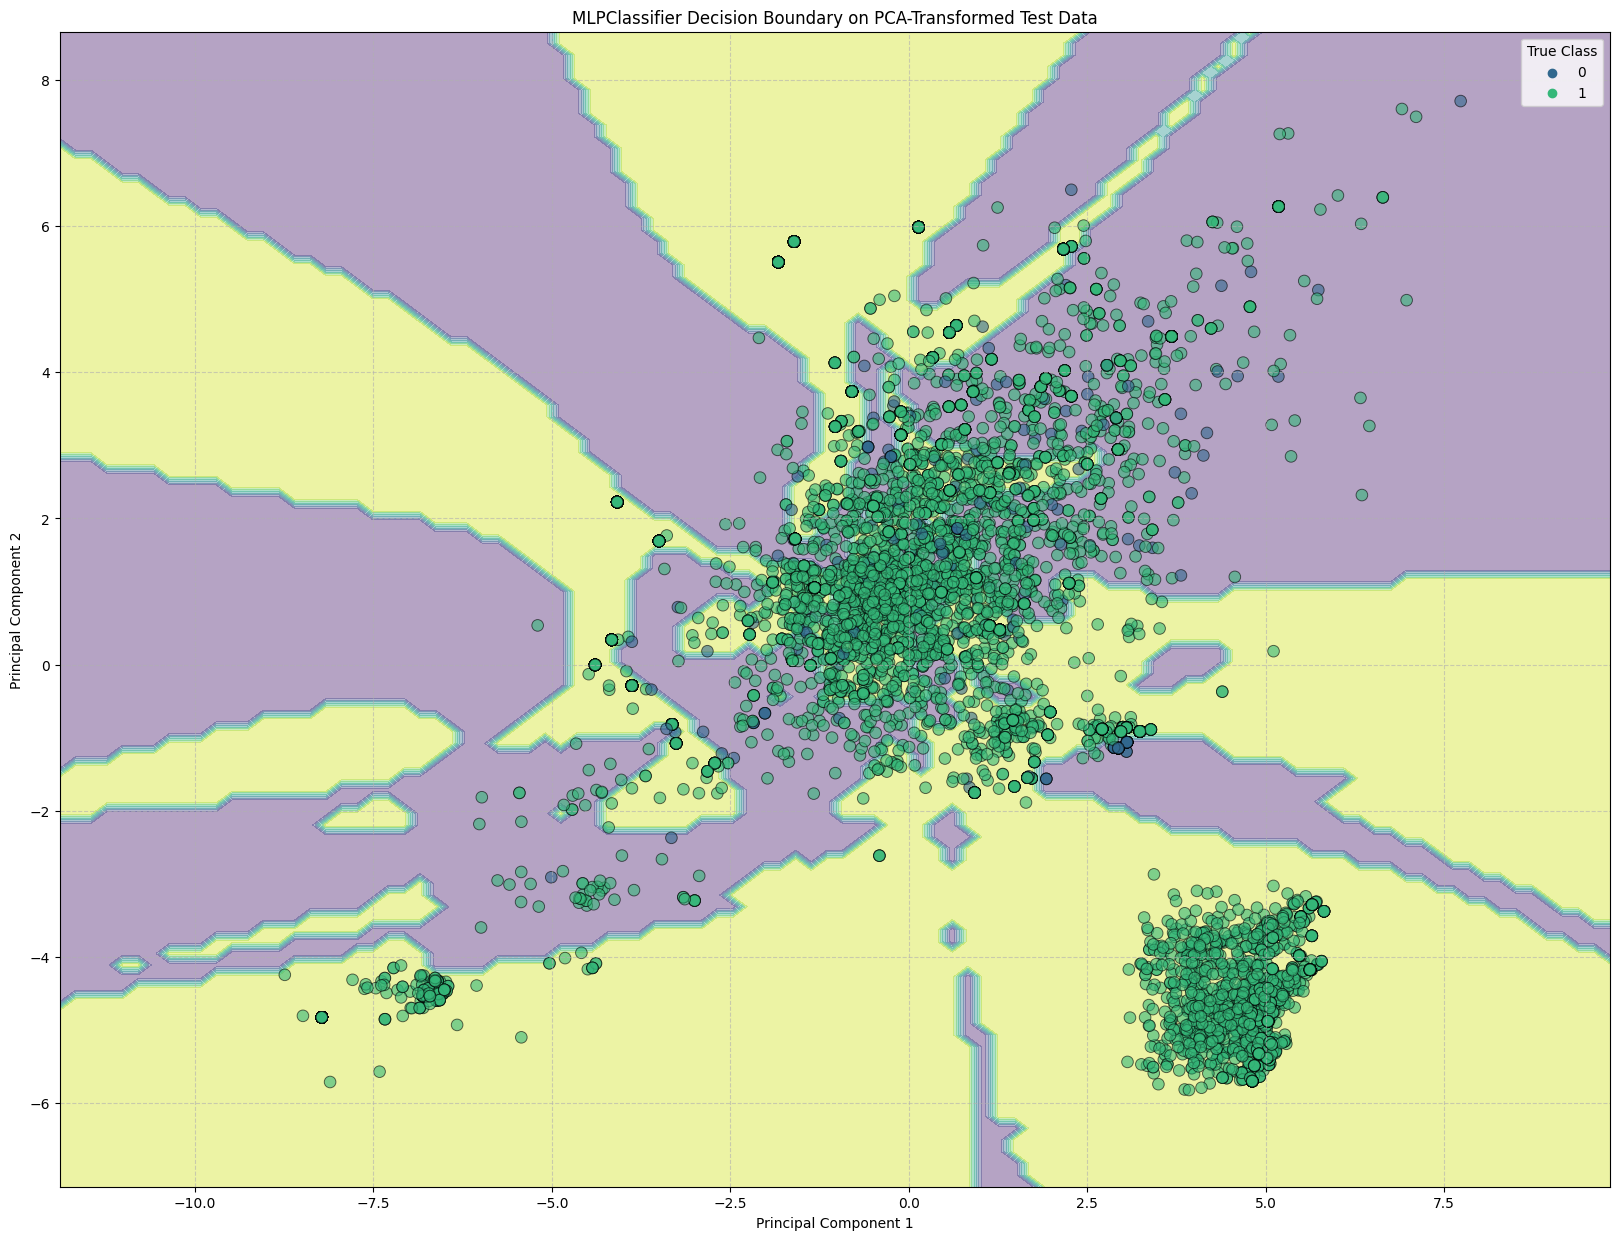

In [29]:
# You can also plot the test data on the same decision boundary to see
# how well the model generalizes.
plot_data_test = pd.DataFrame({
    'PC1': x_test[:, 0],
    'PC2': x_test[:, 1],
    'Target': y_test
})

plt.figure(figsize=(20, 15)) # Consistent figure size
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis) # Plot the same decision regions

sns.scatterplot(
    data=plot_data_test,
    x="PC1",
    y="PC2",
    hue="Target",
    palette="viridis",
    alpha=0.6, # Consistent alpha
    edgecolor='k',
    s=70
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("MLPClassifier Decision Boundary on PCA-Transformed Test Data")
plt.legend(title="True Class")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()